# HW11 Task 2 - Linear model
# KNN, LMNN, SVM, ENN

In [1]:
#install packets
#!pip3 install pylmnn
# !pip install enn

In [6]:
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import time
import timeit

from enn.enn import ENN
from numba.decorators import autojit
from pylmnn import LargeMarginNearestNeighbor as LMNN
from scipy.spatial.distance import euclidean, mahalanobis, minkowski, chebyshev
from sklearn.neighbors import DistanceMetric
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle

%matplotlib inline
# matplotlib.style.use('seaborn')

print (sklearn.__version__)

0.20.2


In [7]:
# path to data
path='winequality-red.csv'
df=pd.read_csv(path, sep=";")
df.head()
# data size
print('\n shape: ',df.shape)

# data info
df.describe()

# target count
type=df['quality'].groupby(df['quality']).count()
print('\n type: ',type)


 shape:  (1599, 12)

 type:  quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64


In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


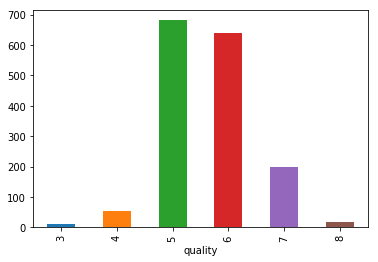

In [9]:
# count target plot
type.plot('bar');

In [10]:
# input data

# get column titles except the last column
features=df.columns[:-1].tolist()

# get data set features
X=df[features].values
# get labels
y=df['quality'].values

# split data to train data set and test data set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)

In [6]:
%%time
# KNN && Gridsearch
n_neighbors_array = list(range(1,31))
param_grid={'n_neighbors':n_neighbors_array, 'algorithm':['kd_tree','ball_tree'],\
            'metric':['chebyshev','manhattan','minkowski'], 'weights':['uniform','distance']}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, iid=True)

grid.fit(X_train, y_train)

best_neighbors = grid.best_params_.get('n_neighbors')

print(f'best score: {grid.best_score_:.3f}  nieghbor: {best_neighbors}')
print(f'prediction precision rate: {grid.score(X_test,y_test):.5f}')

best score: 0.619  nieghbor: 25
prediction precision rate: 0.64000
Wall time: 1min 4s


In [7]:
%%time
# KNN & LMNN metric GridSearchSV

# LMNN metric
scores = []
# paraments for GridSearchCV
#k_test_neighbors_array = list(range(1,10))
param_grid_knn={'n_neighbors':[1], 'algorithm':['kd_tree','ball_tree'],\
            'metric':['chebyshev','manhattan','minkowski'], 'weights':['uniform','distance']}

# loop k from 1 to 5, and get cross validation score of each K value
n_components, max_iter = X.shape[1], 5

for k in range(1,9):
    start_time = timeit.default_timer()
    # Instantiate the metric learner
    lmnn = LMNN(n_neighbors=k, max_iter=max_iter, n_components=n_components)
    # Train the metric learner
    lmnn.fit(X_train, y_train)
     
    #KNN Algorytm
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid_knn, cv=5, iid=True)
    
    grid.fit(lmnn.transform(X_train), y_train)
    
    best_neighbors = grid.best_params_.get('n_neighbors')
    
    end_time = timeit.default_timer() - start_time
    
    print(f'best score: {grid.best_score_:.3f}   nieghbor LMNN: {k}')
    print(f'prediction precision rate: {grid.score(X_test,y_test):.5f}')
    print(f'time: {end_time:.0f} s \n')

    scores.append([grid.best_score_, best_neighbors, grid.score(X_test,y_test), k])

result_scores = sorted(scores, key=lambda x: x[0], reverse=True)[0]
print('\nResult Nieghbor LMNN algorytm')
print(f'nieghbor LMNN: {result_scores[3]} score: {result_scores[2]}  predict precision rate: {result_scores[0]:.3f}')

# KNN model 
best_k = result_scores[3]
# Instantiate the metric learner
lmnn = LMNN(n_neighbors=int(best_k), max_iter=max_iter, n_components=n_components)
# Train the metric learner
lmnn.fit(X_train, y_train)

# generate KNN model & GridSearchCV
knn=KNeighborsClassifier(n_neighbors=best_k)

param_grid_knn={'n_neighbors':[best_k], 'algorithm':['kd_tree','ball_tree'],\
            'metric':['chebyshev','manhattan','minkowski'], 'weights':['uniform','distance']}

grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, iid=True)
# fit with train data set
grid_knn.fit(lmnn.transform(X_train), y_train)

print(f'\nprediction precision rate: {grid_knn.score(lmnn.transform(X_test),y_test):.5f}')

best score: 0.569   nieghbor LMNN: 1
prediction precision rate: 0.48250
time: 4 s 

best score: 0.564   nieghbor LMNN: 2
prediction precision rate: 0.37000
time: 3 s 

best score: 0.568   nieghbor LMNN: 3
prediction precision rate: 0.41000
time: 3 s 

best score: 0.569   nieghbor LMNN: 4
prediction precision rate: 0.05250
time: 6 s 

best score: 0.579   nieghbor LMNN: 5
prediction precision rate: 0.42250
time: 4 s 

best score: 0.565   nieghbor LMNN: 6
prediction precision rate: 0.42250
time: 4 s 

best score: 0.590   nieghbor LMNN: 7
prediction precision rate: 0.39500
time: 7 s 

best score: 0.585   nieghbor LMNN: 8
prediction precision rate: 0.42000
time: 5 s 


Result Nieghbor LMNN algorytm
nieghbor LMNN: 7 score: 0.395  predict precision rate: 0.590

prediction precision rate: 0.65500
Wall time: 43.1 s


In [8]:
%%time
# KNN & LMNN metric GridSearchSV less

# LMNN metric
#https://pylmnn.readthedocs.io/en/stable/api.html#module-pylmnn.lmnn

scores=[]
# loop k from 1 to 9, and get cross validation score of each K value
k_test, n_components, max_iter = 1, X.shape[1], 10

for k in range(1,9):
    start_time = timeit.default_timer()
    # Instantiate the metric learner
    lmnn = LMNN(n_neighbors=k, max_iter=max_iter, n_components=n_components)
    # Train the metric learner
    lmnn.fit(X_train, y_train)
    # Fit the nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k_test, algorithm='kd_tree', metric='chebyshev', weights='uniform')
    knn.fit(lmnn.transform(X_train), y_train)
    score_val=cross_val_score(knn,lmnn.transform(X_train),y_train,scoring='accuracy',cv=5)
    score_mean=score_val.mean()
    scores.append(score_mean)
    
    end_time = timeit.default_timer() - start_time
    
    print(f'neibors: {k}  ->  score: {score_mean:.5f}  <-  time: {end_time:.0f} s')

# KNN model 

# get index of maxium score along axis, default axis=0 for 1 dimensional array
best_k=np.argmax(scores)+1
print('\nneibor:',best_k)
# Instantiate the metric learner
lmnn = LMNN(n_neighbors=int(best_k), max_iter=max_iter, n_components=n_components)
# Train the metric learner
lmnn.fit(X_train, y_train)
# generate KNN model
knn=KNeighborsClassifier(n_neighbors=best_k)
# fit with train data set
knn.fit(lmnn.transform(X_train), y_train)
# get Modes presicion rate using test set
print(f'prediction precision rate: {knn.score(lmnn.transform(X_test),y_test):.5f}')

neibors: 1  ->  score: 0.55307  <-  time: 4 s
neibors: 2  ->  score: 0.56645  <-  time: 3 s
neibors: 3  ->  score: 0.56310  <-  time: 2 s
neibors: 4  ->  score: 0.58141  <-  time: 3 s
neibors: 5  ->  score: 0.58055  <-  time: 6 s
neibors: 6  ->  score: 0.60558  <-  time: 8 s
neibors: 7  ->  score: 0.59052  <-  time: 6 s
neibors: 8  ->  score: 0.57470  <-  time: 8 s

neibor: 6
prediction precision rate: 0.59000
Wall time: 47 s


In [44]:
%%time
# SVC model GridSearchSV

gamma_aray = np.linspace(0.35, 0.55, 30).tolist()
parameters_svc = {'gamma':gamma_aray, 'C':[1,10]}
svc = SVC()
clf = GridSearchCV(svc, parameters_svc, cv=5)
clf.fit(X_train, y_train);

print('\nevalueted paremetrs SVC: ',clf.best_params_)
print(f'prediction precision rate: {clf.score(X_test,y_test):.5f} \n')

y_pred = clf.predict(X_test)

print('Train scores: \n')
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')


evalueted paremetrs SVC:  {'C': 1, 'gamma': 0.3775862068965517}
prediction precision rate: 0.56500 

Train scores: 

accuracy_score = 0.56500
precision_score = 0.33886
recall_score = 0.25505
f1_score = 0.26192 

Wall time: 2min 24s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
%%time
# SVC model GridSearchSV less

# The implementation is based on libsvm. 
# The fit time complexity is more than quadratic with the number of samples 
# which makes it hard to scale to dataset with more than a couple of 10000 samples.

clf = SVC(gamma=0.53, C=1)
clf.fit(X_train, y_train)
print(f'prediction precision rate: {clf.score(X_test,y_test):.5f} \n')

y_pred = clf.predict(X_test)

print('Train scores: \n')
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')
#print('roc_auc_score = ', roc_auc_score(y_train, y_pred))

prediction precision rate: 0.56500 

Train scores: 

accuracy_score = 0.56500
precision_score = 0.33951
recall_score = 0.24890
f1_score = 0.25092 

Wall time: 626 ms


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
%%time
# ENN model GridSearchSV
# https://github.com/timo-stoettner/ENN/blob/master/README.md
# article https://mlbootcamp.ru/article/tutorial/

# optimized function for euclidean metric in ENN
def euclidean(x,y):   
    return np.sqrt(np.sum((x-y)**2))

optimized_euclidean = autojit(euclidean)

k_array = list(range(1,3))
parameters_enn = {'k':k_array, 'distance_function':[optimized_euclidean]}
enn = ENN()
clf = GridSearchCV(enn, parameters_enn, cv=5)
clf.fit(X_train, y_train)
print('\nevalueted paremetrs ENN: ',clf.best_params_)

y_pred = clf.predict(X_test)

print('\n Model ENN: ')
print(' Train scores: \n')
print(f' accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f' precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f' recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f' f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')


evalueted paremetrs ENN:  {'distance_function': CPUDispatcher(<function euclidean at 0x000000000BA2CC80>), 'k': 1}

 Model ENN: 
 Train scores: 

 accuracy_score = 0.52000
 precision_score = 0.28674
 recall_score = 0.31960
 f1_score = 0.29066 

Wall time: 44.5 s


In [12]:
%%time
# ENN model  GridSearchSV less
# https://github.com/timo-stoettner/ENN/blob/master/README.md
# article https://mlbootcamp.ru/article/tutorial/

clf = ENN(k=1, distance_function=optimized_euclidean)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('\n Model ENN: ')
print(' Train scores: \n')
print(f' accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f' precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f' recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f' f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')


 Model ENN: 
 Train scores: 

 accuracy_score = 0.52000
 precision_score = 0.28674
 recall_score = 0.31960
 f1_score = 0.29066 

Wall time: 1.8 s


In [13]:
# Scoring improvement

# Get balanced sample by oversampling
def balanced_koef(serie, element):
    '''evaluation multiply koefficient'''
    return (serie.max() // serie[element])

# balancing algorytm - primitive upsampling 

aray_df = []
for i in type.index:
    
    df_target = df[df['quality'] == i]
    
#     if balanced_koef(type, i) != 0:
#         df_target = pd.concat([df_target] * balanced_koef(type, i))
    df_target = pd.concat([df_target] * balanced_koef(type, i))
    aray_df.append(df_target)

df_balanced = pd.concat(aray_df)

print(f'df: {df.shape}  -->>  balanced df: {df_balanced.shape}')

df: (1599, 12)  -->>  balanced df: (3898, 12)


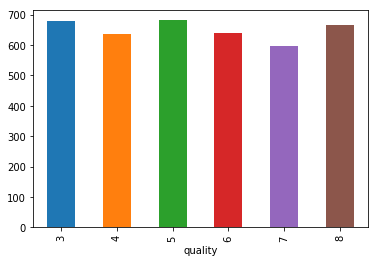

In [14]:
# Count balances type in dataset
type_balanced=df_balanced['quality'].groupby(df_balanced['quality']).count()
type_balanced.plot('bar');
df_balanced = shuffle(df_balanced)

In [15]:
# Balanced dataframe

# df.columns is column labels property
features=df_balanced.columns[:-1].tolist()
X = df_balanced[features].values
y = df_balanced['quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)

# set y to arrays
y_train = y_train.values
y_test = y_test.values

In [56]:
%%time
# KNN && Gridsearch
n_neighbors_array = list(range(1,11))
param_grid={'n_neighbors':n_neighbors_array, 'algorithm':['kd_tree','ball_tree'],\
            'metric':['chebyshev','manhattan','minkowski'], 'weights':['uniform','distance']}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, iid=True)

grid.fit(X_train, y_train)

best_neighbors = grid.best_params_.get('n_neighbors')

print(f'best score: {grid.best_score_:.3f}  nieghbor: {best_neighbors}')
print(f'prediction precision rate: {grid.score(X_test,y_test):.5f}')

best score: 0.856  nieghbor: 1
prediction precision rate: 0.86564
Wall time: 45.4 s


In [16]:
%%time
# ENN model balanced DF & GridSearchSV

k_array = list(range(1,3))
parameters_enn = {'k':k_array, 'distance_function':[optimized_euclidean]}
enn = ENN()
clf = GridSearchCV(enn, parameters_enn, cv=5)
clf.fit(X_train, y_train)
print('\nevalueted paremetrs ENN: ',clf.best_params_)

y_pred = clf.predict(X_test)

print('\n Model ENN: ')
print(' Train scores: \n')
print(f' accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f' precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f' recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f' f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')


evalueted paremetrs ENN:  {'distance_function': CPUDispatcher(<function euclidean at 0x000000000BA2CC80>), 'k': 1}

 Model ENN: 
 Train scores: 

 accuracy_score = 0.86462
 precision_score = 0.85787
 recall_score = 0.86495
 f1_score = 0.86069 

Wall time: 3min 37s
